In [116]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [117]:
df = pd.read_excel("/Users/surajkwork/Documents/Thesis/thesis/df.xlsx")

The date variable is not in datetime format so it has to be converted.

In [118]:
df['date']= pd.to_datetime(df['date'])
df.index = df['date']
df.sort_index(inplace=True)

Extracting one cluster from the dataset for analysis.

In [119]:
TS1 = df[(df['Plz'] == "['25', '24']")]

And from this cluster, extracting one category for analysis.

In [120]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']

In [121]:
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

In [122]:
datasets = [TS1_A2, TS1_A1A2, TS1_A2A3]

# Modelling - Train, test split

In [123]:
nobs = 6
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

## ARIMA Model


### Static forecast using ARIMA


No retraining. We just use the best ARIMA model to forecast for the test set and evaluate.
We use the once-trained best ARIMA model to forecast for the 6 "steps" in one go. 

In [124]:
model = ARIMA(df_train['wPreis'], order=(4, 1, 0))
static_ARIMA = model.fit()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [125]:
static_ARIMA.forecast(steps=nobs) 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


148     9.790221
149    10.235383
150     5.506046
151     4.813487
152     6.839276
153     5.841581
Name: predicted_mean, dtype: float64

The ARIMA forecast function does not require an "input" other than the steps, so either
- we can do a static forecast (train once on the entire training dataset) and test the predictions for the required steps to compare with the test dataset or
- train in a walk-forward validation where we retrain the model with every step of the test dataset on the new training set which includes the new observation

In [126]:
fc = static_ARIMA.forecast(steps=nobs) 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [127]:
a = np.array(fc)
test= pd.DataFrame(a, columns=['E'])
df_forecast = pd.DataFrame(a, index=df_test.index[-nobs:], columns=['Predicted_wPreis'])

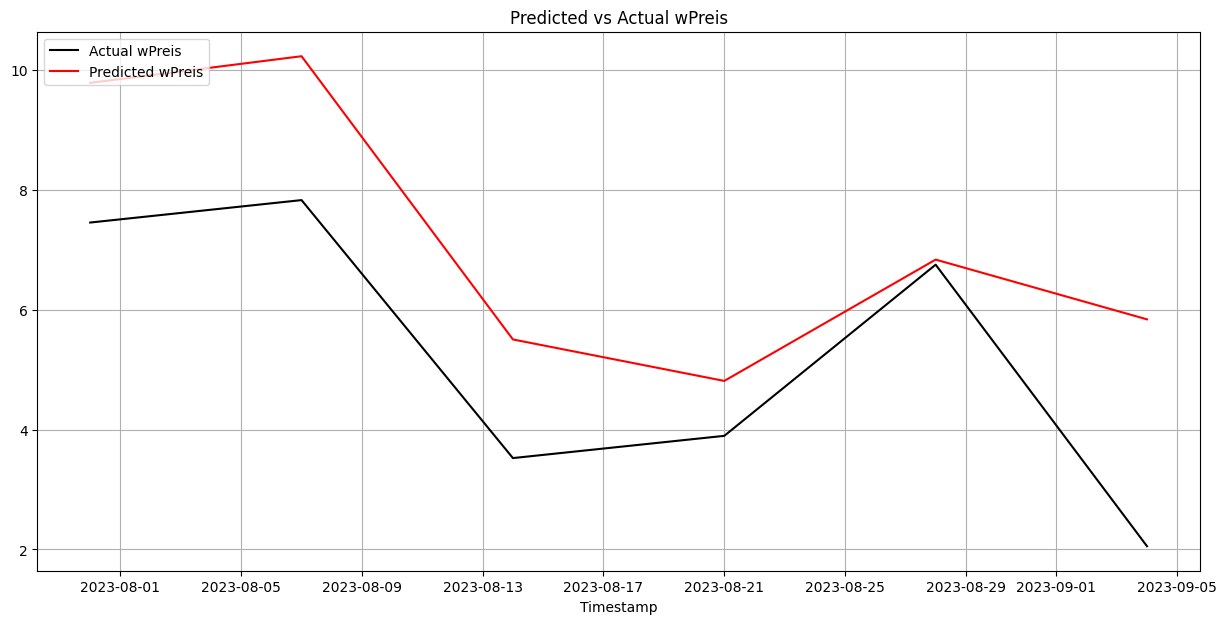

In [128]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 7))
plt.plot(df_test["wPreis"], color='black', label='Actual wPreis')
plt.plot(df_forecast, color='red', label='Predicted wPreis')
plt.xlabel("Timestamp")
plt.grid(True)
plt.legend(loc='upper left')
plt.title('Predicted vs Actual wPreis')
plt.show()

We will define a forecast accuracyy function that will calculate the mean error, RMSE and also the direction accuracy. 

In [129]:
def forecast_accuracy(forecast, actual):
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [130]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Forecast Accuracy of: wPreis')
accuracy_prod = forecast_accuracy(df_forecast['Predicted_wPreis'].values, df_test['wPreis'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: wPreis
me     :  1.9176
rmse   :  2.2485
direction_accuracy :  0.8


## Trying ~~ comparison with rolling window ~~ (not relevant)

In [131]:
window = df_train['wPreis'][-4:].tolist() 

In [132]:
# one-step out of sample forecast
start_index = len(df_train)
end_index = len(df_train)
static_ARIMA.predict(start=start_index, end=end_index)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


148    9.790221
dtype: float64

In [133]:
test = df_test['wPreis'].tolist()

In [134]:
rolling_predictions = list()
rolling_expect=[]

# Iterate over each step in the test set
for t in range(len(test)):
    output = static_ARIMA.predict(start=start_index+t, end=end_index+t)  # Going through each of the t and predicting for that tth step. 
    obs = test[t]
    rolling_predictions.append(output)
    print(rolling_predictions)


[148    9.790221
dtype: float64]
[148    9.790221
dtype: float64, 149    10.235383
dtype: float64]
[148    9.790221
dtype: float64, 149    10.235383
dtype: float64, 150    5.506046
dtype: float64]
[148    9.790221
dtype: float64, 149    10.235383
dtype: float64, 150    5.506046
dtype: float64, 151    4.813487
dtype: float64]
[148    9.790221
dtype: float64, 149    10.235383
dtype: float64, 150    5.506046
dtype: float64, 151    4.813487
dtype: float64, 152    6.839276
dtype: float64]
[148    9.790221
dtype: float64, 149    10.235383
dtype: float64, 150    5.506046
dtype: float64, 151    4.813487
dtype: float64, 152    6.839276
dtype: float64, 153    5.841581
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction r

 Now we get the same as static forecast. Which again suggests that there is no meaning to a rolling forecast without retraining. And retraining would be the walk-forward validation. 

# Walk forward validation using ARIMA model

Training the whole model at each iteration including the new observation (for the next day)  

In [135]:
X = TS1_A1A2["wPreis"].values

Take 148 observations for training and 6 for testing.

In [136]:
size = 148
train, test = X[0:size], X[size:len(X)] 

In [137]:
history = [x for x in train] # "list comprehensions". 
expect=[]

In [138]:
predictions = list()
for t in range(len(test)): # 6 times reiterate
    model = ARIMA(history, order=(4,1,0))  
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs) # appends the real observation at each loop! 
    expect.append(obs)

    
# print(expect)
# print(predictions)

In [139]:
df_wPreis = pd.DataFrame(
    {'observations': expect,
     'forecast': predictions, 
    })


In [140]:
def adjust(val, length= 10): return str(val).ljust(length) # 10
print('Forecast Accuracy of wPreis')
accuracy_prod = forecast_accuracy(df_wPreis['forecast'].values, df_wPreis['observations'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of wPreis
me         :  0.5185
rmse       :  1.9551
direction_accuracy :  0.4


Here, the me and rmse has improved but the direction_accuracy has decreased even further!

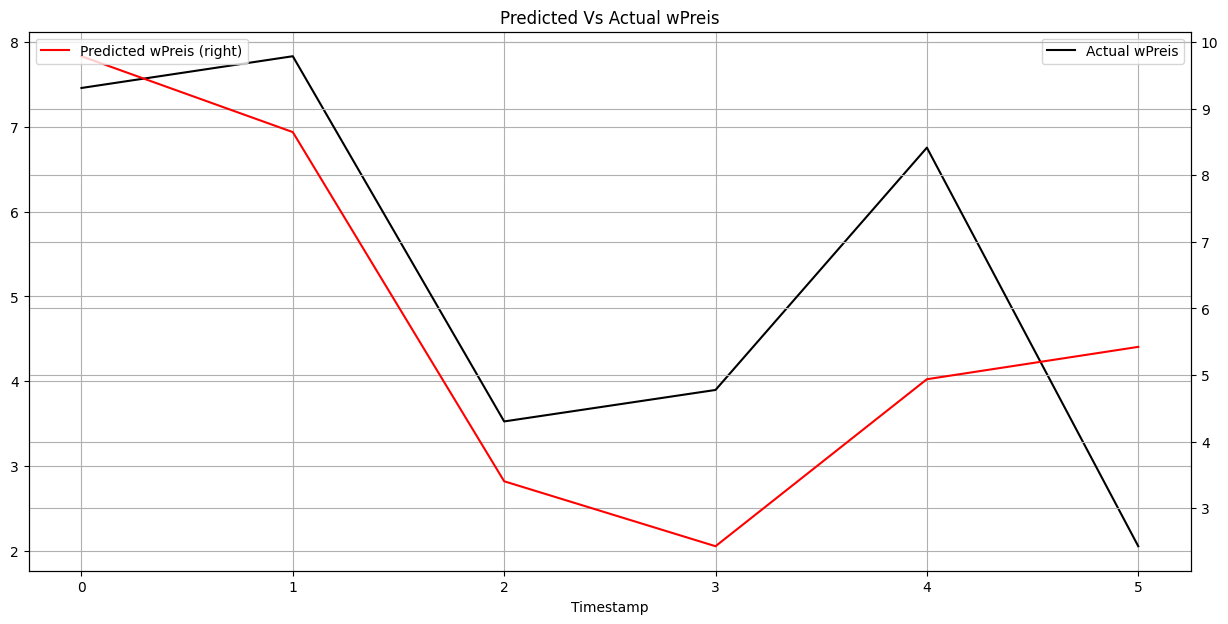

In [141]:
plt.figure(figsize= (15,7))
plt.xlabel("Timestamp")

ax1 = df_wPreis.observations.plot(color = 'black', grid = True, label = 'Actual wPreis')
ax2 = df_wPreis.forecast.plot(color = 'red', grid = True, secondary_y = True, label = 'Predicted wPreis')

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('Predicted Vs Actual wPreis')
plt.show()